# Multidisciplinary Design Optimization of LV4
We propose to apply design optimization methodology to the problem of design and trajectory optimization of small sounding rockets, particularly to the Portland State Aerospace Society's LV4 'space rocket'. This rocket leverages powerful liquid-fuel propulsion, a carbon-composite airframe, 6 DoF attitude control, and has a design apogee of over 100 km, above the so-called von Karman line. LV4 is currently planned for launch by 2021. 

The large amount of coupling between the design decisions in aerospace engineering design presents a singularly defining difficulty in launch vehicle development. In practice this results in a highly iterative design process that demands large investments of resources and time. This also tends to lead to a one-variable-at-a-time design thinking with concomitant requirement mismatches, developmental dead-ends and sub-optimal final design. The Portland State Aerospace Society (PSAS), being a university student group, lacks both time and fiscal support to pursue the traditional iterative approach to launch vehicle design in time for the 2021 vision goal launch date. This provides the motivation for a more targeted approach where design requirements are led by simulation and major design variables are treated all at once using convex optimization techniques. This will guid PSAS's technology development pathways, and inform requirements for future senior capstone projects sponsored by the organization. There is also a certain novelty to this work in the sense that historically there has been little published attention paid to the problem of parameter optimization in clean-sheet design of small sounding rockets.

The objective function is a summation of mass terms for the rocket including propellant, airframe and various subsystem masses. This sum represent a Gross-Lift-Off-Weight (GLOW) parameter which scales closely with design complexity and, ultimately, overall costs. Thus we wish to minimize GLOW subject to constraints including the requirement of a 100 km trajectory apogee, a Thrust-To-Weight-Ratio (TWR) greater than one, a Length-to-Diameter-Ratio (LDR) of less than 20, and a currently unspecified maximum allowable airframe dynamic pressure. Design variables include thrust, airframe diameter and length. The trajectory constraint is a simulation model using forward-Euler integration implemented in Python. There are also a large number of design constants present in the models, which include specific impulse and combustion chamber pressure, mixture ratio among others.

The optimization scheme to be used is yet to be determined, though the nature of the optimization problem is such that it is strongly non-linear with some constraints in the form of discrete simulation outputs.

## Methods
Objective function: minimize $m$  
Design variables: $m_{wet}=f(r, L)$, $m_{dry}=f(F)$, $mdot$, $radius$, $p_e$, $p_ch$  
Constraints: $L/D<30$, $TWR>1$, Sommerfield criterion $(p_e/p_a)>0.35$, $3<radius<7$, $x>=100000$, $a/g_0<=15$    

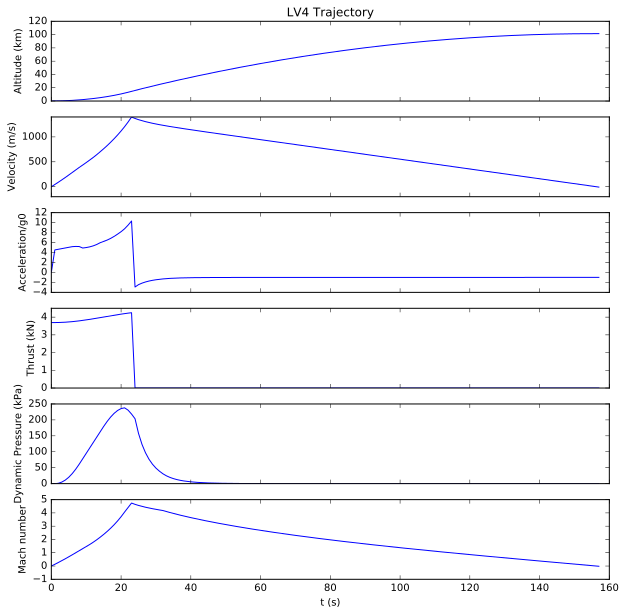

altitude at apogee = 101.4 km
mission time at apogee = 157.0 s
TWR at lift off (check TWR > 1) = 4.51
design total propellant mass = 36.283
design thrust (sea level) = 3.7 kN
design thrust (vacuum) = 4.2 kN
design burn time = 24 s
design expansion ratio = 5.8
design throat area = 1.7 in^2
design isp = 251.5
Sommerfield criterion (check pe/pa >= 0.3) = 0.5
design dV = 1.869956815824683 km/s c.f. required potential energy est = 1.4106622438196303 km/s


In [1]:
#A lazy start towards a simple forward Euler integration for rocket trajectories
#-Erin Schmidt

#This whole thing will be a module called by the optimizer (test w/ aerobee data? or another Single stage LF sounding rocket?)

from math import sqrt, pi, exp, log, cos
import numpy as np

def dry_mass(L, A):
    m_avionics = 2
    m_recovery = 2
    m_payload = 2
    m_tankage = 2*L
    m_engine = 1
    m_feedsys = 20
    m_airframe  = 1
    return (m_avionics + m_recovery + m_payload + m_tankage 
    + m_engine + m_feedsys + m_airframe)
    
def propellant_mass(A, L, OF=1.3):
    rho_alc = 852.3 #density of ethanol fuel [kg/m^3]
    rho_lox = 1141.0 #density of lox [kg/m^3]
    L_lox = L/(rho_lox/(rho_alc*OF) + 1)
    m_lox = rho_lox*L_lox*A #oxidizer mass [kg]
    m_alc = rho_alc*(L-L_lox)*A #fuel mass [kg]
    return m_alc + m_lox

def std_at(h): #U.S. 1976 Standard Atmosphere
    if h < 11000:
        T = 15.04 - 0.00649*h
        p = 101.29*((T + 273.1)/288.08)**5.256
    
    elif 11000 <= h and h <25000:
        T = -56.46
        p = 22.65*exp(1.73 - 0.000157*h)
    
    else:
        T = -131.21 + 0.00299*h
        p = 2.488 * ((T + 273.1)/216.6)**(-11.388)
        
    rho = p/(0.2869*(T + 273.1)) #ambient air density
    p_a = p*1000 #ambient air pressure
    T_a = T + 273.1 #ambient air temperature
    return p_a, rho, T_a
    
def thrust(x, p_ch, T_ch, p_e, ke, Re, mdot):
    p_a = std_at(x)[0] 
    p_t = p_ch*(1 + (ke - 1)/2)**(-ke/(ke - 1)) #Throat pressure
    T_t = T_ch*(1/(1 + (ke - 1)/2)) #Throat temperature
    A_t = (mdot / p_t)*sqrt(Re*T_t/ke) #Throat area
    A_e = A_t*(2/(ke + 1))**(1/(ke - 1))*(p_ch/p_e)**(1/ke) * 1/sqrt((ke + 1)/(ke - 1)*(1 - (p_e/p_ch)**((ke - 1)/ke))) #Exit area
    ex = A_e/A_t
    alpha_t = [14, 11, 10, 9] #lookup table of divergence angles, assuming 80% bell
    ex_t = [5, 10, 15, 20]
    alpha= np.interp(ex, ex_t, alpha_t)
    lam = 0.5*(1 + cos(alpha *pi/180))
    Ve = lam*sqrt(2*ke/(ke - 1)*Re*T_ch*(1 - (p_e/p_ch)**((ke - 1)/ke))) #exhaust velocity
    #It would be great to find cosine loss as a function of expansion ratio(is it ~0.1*F?)
    F = mdot*Ve + (p_e - p_a)*A_e  #Thrust force, ignoring that isp increases w/ p_ch
    return F, A_t, A_e, Ve

def drag(x, v, A, Ma):
    #check Knudsen number and switch drag models (e.g. rarified gas dyn vs. quadratic drag)
    (p_a, rho, T_a) = std_at(x)
    C_d_t = [0.15, 0.15, 0.3, 0.45, 0.25, 0.2, 0.175, .15, .15] #super cheesy lookup table for drag coefficients (historical data for V-2)
    Ma_t = [0, 0.6, 1.0, 1.1, 2, 3, 4, 5, 5.6]
    C_d = np.interp(Ma, Ma_t, C_d_t)
    
    """
    drag coefficient, placeholder scalar constant should be a function of Mach number 
    e.g. run some simulations in Star and curve fit via Cd = a*Ma**b + C_d0
    """
    
    q = 0.5 * rho * v**2 #dyanmic pressure [Pa]
    D = q * C_d * A #drag force [N]
    return D, q
    
def trajectory(L, mdot, dia, p_e, p_ch=350, T_ch=3500, ke=1.3, Re=349, x_init=0):
    #Note combustion gas properties ke, Re, T_ch, etc, determined from CEA
    
    #physical constants
    g_0 = 9.81 #gravitational acceleration
    dt = 1 #time step
    ka = 1.4 #Ratio of specific heats, air
    Ra = 287.1 #avg. specific gas constant (dry air)

    #LV design variables
    dia = dia*0.0254 #convert in to m
    A = pi*(dia/2)**2 #airframe frontal area projected onto a circle of raduis r
    m_dry = dry_mass(L, A) #dry mass, call from function
    mdot = mdot #mass flow rate
    p_ch = p_ch*6894.76 #chamber pressure, convert psi to Pa
    p_e = p_e*1000 #exit pressure, convert kPa to Pa


    #initial conditions
    x = [x_init]
    v = [0]
    a = [0]
    t = [0]
    rho = [std_at(x[-1])[1]]
    p_a = [std_at(x[-1])[0]]
    T_a = [std_at(x[-1])[2]]
    m_prop = [propellant_mass(A, L)]
    m = [m_dry + m_prop[-1]]
    (F, A_t, A_e, Ve) = thrust(x[-1], p_ch, T_ch, p_e, ke, Re, mdot)
    F = [F]
    D = [0]
    Ma = [0]
    q = [0]
    r = (m_prop[0] + m_dry)/m_dry #mass ratio
    dV1 = Ve*log(r)/1000 #Tsiolkovsky's bane
    
    while True:
        p_a.append(std_at(x[-1])[0])
        rho.append(std_at(x[-1])[1])
        T_a.append(std_at(x[-1])[2])
        if m_prop[-1] > 0:
            (Fr, A_t, A_e, Ve) = thrust(x[-1], p_ch, T_ch, p_e, ke, Re, mdot)
            F.append(Fr)
            m_prop.append(m_prop[-1] - mdot*dt)
            mdot_old = mdot
        else:
            Ve = thrust(x[-1], p_ch, T_ch, p_e, ke, Re, mdot_old)[3]
            F.append(0)
            mdot = 0
            m_prop[-1] = 0
        q.append(drag(x[-1], v[-1], A, Ma[-1])[1])
        D.append(drag(x[-1], v[-1], A, Ma[-1])[0])
        a.append((F[-1] - D[-1])/m[-1] - g_0)
        v.append(a[-1]*dt + v[-1])
        x.append(v[-1]*dt + x[-1]) 
        Ma.append(v[-1]/sqrt(ka*Ra*T_a[-1]))
        t.append(t[-1] + dt)
        m.append(m_dry + m_prop[-1])
        TWR = a[1]/g_0 #constraint
        ex = A_e/A_t
        S_crit = p_e/p_a[0] #constraint
        if v[-1] <= 0:
            x = np.array(x)
            a = np.array(a)
            F = np.array(F)
            D = np.array(D)
            q = np.array(q)
            return x, v, a, t, F, D, Ma, rho, p_a, T_a, TWR, ex, Ve, A_t, dV1, m, S_crit, q, m_prop
        

#----------------------------------------------------
#TESTING          
#if __name__ == "__main__":

mdot = 0.453592 * 0.9 * 4 # 0.9 lb/s to kg/s (should result in ~1kN if 0.9*1)
p_e =  50 #kPa
p_ch = 350 #psi
dia = 6 #airframe diameter [in]
L = 2 #tankage length [m], keep in mind that the actual airframe will be 2-3 m longer

(x, v, a, t, F, D, Ma, rho, p_a, T_a, TWR, ex, Ve, A_t, dV1, m, S_crit, q, m_prop) = trajectory(L, mdot, dia, p_e, p_ch)

import matplotlib
import matplotlib.pyplot as plt
import pylab
%config InlineBackend.figure_formats=['svg']
%matplotlib inline

pylab.rcParams['figure.figsize'] = (10.0, 10.0)
f, (ax1, ax2, ax3, ax4, ax6, ax7) = plt.subplots(6, sharex=True)
#plt.xlim(0, 1.8)
ax1.plot(t, x/1000)
ax1.set_ylabel("Altitude (km)")
ax1.yaxis.major.locator.set_params(nbins=6)
ax1.set_title('LV4 Trajectory')
ax2.plot(t, v)
ax2.yaxis.major.locator.set_params(nbins=6)
ax2.set_ylabel("Velocity (m/s)")
ax3.plot(t, a/9.81)
ax3.yaxis.major.locator.set_params(nbins=10)
ax3.set_ylabel("Acceleration/g0")
ax4.plot(t, F/1000)
ax4.yaxis.major.locator.set_params(nbins=6)
ax4.set_ylabel("Thrust (kN)")
ax6.plot(t, q/1000)
ax6.yaxis.major.locator.set_params(nbins=6)
ax6.set_ylabel("Dynamic Pressure (kPa)")
ax7.plot(t, Ma)
ax7.yaxis.major.locator.set_params(nbins=6) 
ax7.set_ylabel("Mach number")
ax7.set_xlabel("t (s)")
plt.show()

print('altitude at apogee = {0:.1f} km'.format(x[-1]/1000))
print('mission time at apogee = {0:.1f} s'.format(t[-1]))
print('TWR at lift off (check TWR > 1) = {0:.2f}'.format(TWR))
print('design total propellant mass = {0:.3f}'.format(m_prop[0]))
print('design thrust (sea level) = {0:.1f} kN'.format(F[0]/1000))
j = 0
for i in F:
    if i == 0:
        fdex = j
        break
    j += 1
print('design thrust (vacuum) = {0:.1f} kN'.format(F[fdex - 1]/1000))
print('design burn time = {} s'.format(fdex))
print('design expansion ratio = {0:.1f}'.format(ex))
print('design throat area = {0:.1f} in^2'.format(A_t/0.0254**2))
print('design isp = {0:.1f}'.format(Ve/9.81))
print('Sommerfield criterion (check pe/pa >= 0.3) = {0:.1f}'.format(S_crit))
print('design dV = {} km/s c.f. required potential energy est = {} km/s'.format(dV1, sqrt(2*9.81*x[-1])/1000))

## Mass Model Discussion